In [79]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import time
import random
import torch
import os
import numpy as np
from torchvision.datasets import MNIST, SVHN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# from datasets import getPairedDataset
from model import EncoderA, EncoderB, DecoderA, DecoderB
from util import unpack_data, apply_poe


import sys

sys.path.append("../")
import probtorch
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [80]:
sim_name = "random_18.9k"
train = pickle.load(
    open(
        os.path.join("..", "..", "data", "lgn-v1", sim_name, f"{sim_name}_train.pkl"),
        "rb",
    )
)

X = torch.Tensor(train["responses"]["lgn"]).to(device)
Y = torch.Tensor(train["responses"]["v1"]).to(device)

test = pickle.load(
    open(
        os.path.join("..", "..", "data", "lgn-v1", sim_name, f"{sim_name}_test.pkl"),
        "rb",
    )
)

X_test = torch.Tensor(test["responses"]["lgn"]).to(device)
Y_test = torch.Tensor(test["responses"]["v1"]).to(device)


In [81]:
n_shared = 2
n_privateA = 1
n_privateB = 1
wseed = 0

encA = EncoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
decA = DecoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
encB = EncoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)
decB = DecoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)

decA.load_state_dict(torch.load("../weights/lgn-v1/lgn-v1_6x200_3000epoch_lambda100-decA.rar"))
encA.load_state_dict(torch.load("../weights/lgn-v1/lgn-v1_6x200_3000epoch_lambda100-encA.rar"))
encB.load_state_dict(torch.load("../weights/lgn-v1/lgn-v1_6x200_3000epoch_lambda100-encB.rar"))
decB.load_state_dict(torch.load("../weights/lgn-v1/lgn-v1_6x200_3000epoch_lambda100-decB.rar"))

q = encA(X_test, num_samples=1) 
q = encB(Y_test, num_samples=1, q=q)    

mu_poe, std_poe = apply_poe(
                True,
                q["sharedA"].dist.loc,
                q["sharedA"].dist.scale,
                q["sharedB"].dist.loc,
                q["sharedB"].dist.scale,
            )
q.normal(mu_poe, std_poe, name="poe")


rec_a = decA.forward2(torch.cat((q["privateA"].dist.loc , q["poe"].dist.loc), dim=-1)).squeeze(0).detach().cpu().numpy().reshape(-1,20,20)
rec_b = decB.forward2(torch.cat((q["privateB"].dist.loc , q["poe"].dist.loc), dim=-1)).squeeze(0).detach().cpu().numpy().reshape(-1,40,20)

z_a = q["privateA"].dist.loc.squeeze(0).detach().cpu().numpy()
z_b = q["privateB"].dist.loc.squeeze(0).detach().cpu().numpy()
z_shared = q["poe"].dist.loc.squeeze(0).detach().cpu().numpy()


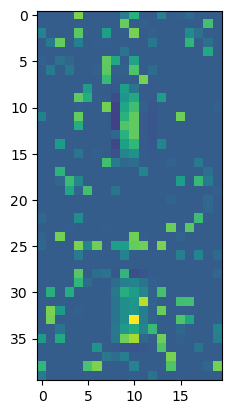

In [82]:
plt.imshow(Y_test[0].detach().cpu().numpy().reshape(40,20), vmin=-.5, vmax=1.2);

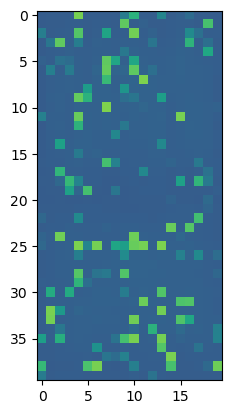

In [83]:
plt.imshow(rec_b[0], vmin=-.5, vmax=1.2); 

In [84]:
rec_a.shape

(3780, 20, 20)

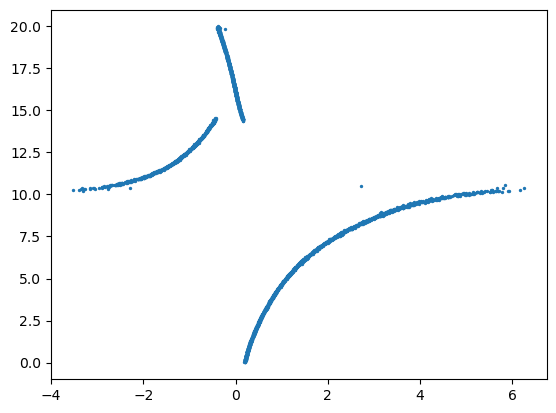

In [85]:
plt.scatter(z_a, test["stim_params"]["lgn_p"], s=2)

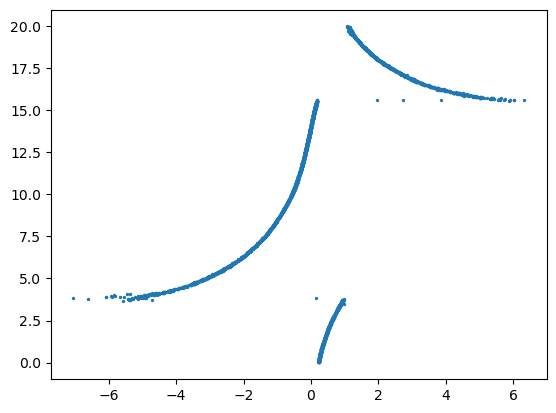

In [86]:
plt.scatter(z_b, test["stim_params"]["v1_p"], s=2)

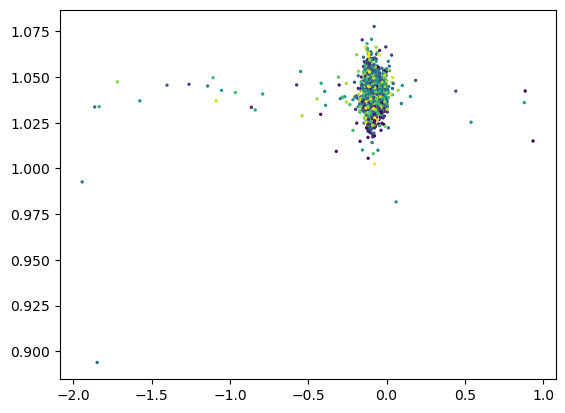

In [87]:
plt.scatter(z_shared[:,0], z_shared[:,1], c=test["stim_params"]["x"],s=2)

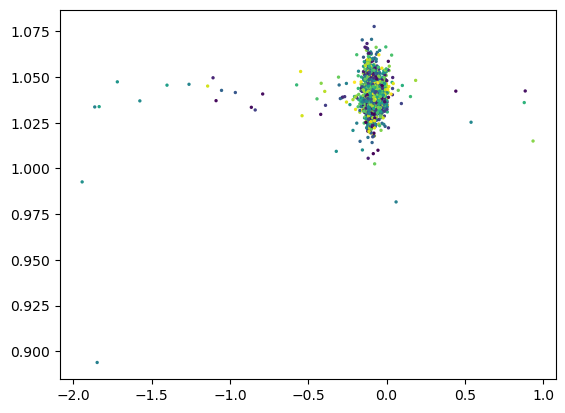

In [88]:
plt.scatter(z_shared[:,0], z_shared[:,1], c=test["stim_params"]["y"],s=2)